### Distilbert embeddings and Sequence Classifier

Here we use the pretrained distilbert-base-uncased model from hugging face (https://huggingface.co/distilbert/distilbert-base-uncased) 

1. First we trained the model with 3 epochs and plotted training and validation loss, observed overfitting at 3rd epoch.
2. To address overfitting we set dropout = 0.3 for regularization, still observed overfitting at 3rd epoch but gave around same results for training and validation loss, but dropout makes the model less overfitting and more robust.
3. Now trained the model to only 2 epoch with dropout=0.3, no overfitting obeserved and the accuracy increased from 0.65 to 0.68. 
4. To address class imbalance issues, class weights were incorporated into the trainer. Higher weights were assigned to classes with fewer samples, while lower weights were given to classes with larger sample sizes while calculating the loss and updating parameters. This adjustment reduced bias in the model. Although it resulted in a slight decrease in accuracy score (~0.08), the model was less biased and fair across all classes.

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
import plotly.express as px
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
import torch

# Assuming you are done with some GPU-based operations
torch.cuda.empty_cache()

### Data preprocessing and preparing datasets

In [2]:
stop_words = set(stopwords.words('english'))
def read_data(file_path):
    df = pd.read_csv(file_path, sep='\t')
    df = df[['claim', 'main_text', 'label']]
    df.dropna(axis=0, inplace=True)

    def preprocess_text(text):
        text = re.sub(r'[#\\\"$”“,:()–’\'/;\[\]{}—‘!+•%&-]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = text.lower()
        return ' '.join([word for word in word_tokenize(text) if word not in stop_words])

    df['main_text'] = df['main_text'].apply(preprocess_text)
    df['claim'] = df['claim'].apply(preprocess_text)

    df = df[df['label'].str.contains('snopes') == False]
    label_dict = {'false': 0, 'true': 1, 'mixture': 2, 'unproven': 3}
    df['label'] = df['label'].map(label_dict)
    return df

In [3]:
def tokenize_data(data, tokenizer):
    return tokenizer(
        data["claim"].tolist(),
        data["main_text"].tolist(),
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

In [4]:
file_paths = {
        "train": "train.tsv",
        "valid": "dev.tsv",
        "test": "test.tsv"
    }

In [5]:
def load_and_preprocess_data(file_paths):
    datasets = {}
    for key, path in file_paths.items():
        df = read_data(path)
        datasets[key] = df
    return datasets

datasets = load_and_preprocess_data(file_paths)

<ipython-input-2-c6aa779dfdd1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=0, inplace=True)


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#input_ids_train, attention_masks_train = get_input_and_attention(df1, tokenizer)
#bert_model = TransformerClassifier('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:

class PUBHEALTHDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        # Store encodings and labels as tensors
        labels = [int(label) if isinstance(label, float) else int(label) for label in labels]
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.encodings = encodings

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Use clone().detach() instead of torch.tensor() for existing tensors
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx].clone().detach()
        return item


In [ ]:
class PUBHEALTHDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):

        labels = [int(label) if isinstance(label, float) else int(label) for label in labels]
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.encodings = encodings

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

In [ ]:
def prepare_datasets(datasets, tokenizer):
    tokenized_datasets = {}

    for key, df in datasets.items():
        df = df.dropna(subset=["label"])

        encodings = tokenize_data(df, tokenizer)
        tokenized_datasets[key] = PUBHEALTHDataset(encodings, df["label"].tolist())

    return tokenized_datasets

tokenized_datasets = prepare_datasets(datasets, tokenizer)

#### Model traning functions

In [ ]:
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer

def train_model(train_dataset, valid_dataset, model,epochs=3,train_batch_size=32,valid_batch_size=32):
    # Define training arguments
    training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",  # Evaluate validation loss after specific steps
    eval_steps=100,               # Evaluate after every 100 steps (same as logging_steps)
    logging_steps=100,            # Log training loss every 100 steps
    learning_rate=2e-5,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=valid_batch_size,
    num_train_epochs=epochs,
    weight_decay=0.05,
    logging_dir="./logs",
    save_strategy="epoch"          # Don't save checkpoints for now (optional)
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset
    )

    # Train the model
    train_output = trainer.train()

    # Fetch the training and evaluation losses
    training_loss = trainer.state.log_history

    # Extract losses
    train_losses = []
    eval_losses = []
    for entry in training_loss:
        if "loss" in entry:  # Training loss
            train_losses.append(entry["loss"])
        if "eval_loss" in entry:  # Validation loss
            eval_losses.append(entry["eval_loss"])

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(eval_losses, label="Validation Loss")
    plt.xlabel("steps(*100)") # need to change this to steps instead of epochs
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

    return trainer

In [26]:
from sklearn.utils.class_weight import compute_class_weight
# Calculate class weights based on training labels
def calculate_class_weights(dataset):
    labels = dataset['label'].values
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(labels),
        y=labels
    )
    return torch.tensor(class_weights, dtype=torch.float)

In [21]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device)  # Move weights to GPU/CPU

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights)  # Use weighted loss
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [22]:
def train_model_with_weights(train_dataset, valid_dataset, model,epochs=3,train_batch_size=32,valid_batch_size=32):
    # Calculate class weights
    class_weights = calculate_class_weights(datasets["train"])  # Using the train dataset

    # Define training arguments
    training_args = TrainingArguments(
      output_dir="./results",
      evaluation_strategy="steps",  # Evaluate validation loss after specific steps
      eval_steps=100,               # Evaluate after every 100 steps (same as logging_steps)
      logging_steps=100,            # Log training loss every 100 steps
      learning_rate=2e-5,
      per_device_train_batch_size=train_batch_size,
      per_device_eval_batch_size=valid_batch_size,
      num_train_epochs=epochs,
      weight_decay=0.05,
      logging_dir="./logs",
      save_strategy="epoch"          # Don't save checkpoints for now (optional)
      )

    # Initialize the custom weighted trainer
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        class_weights=class_weights,
        eval_dataset=valid_dataset
    )

    # Train the model
    train_output = trainer.train()

    # Fetch the training and evaluation losses
    training_loss = trainer.state.log_history

    # Extract losses
    train_losses = []
    eval_losses = []
    for entry in training_loss:
        if "loss" in entry:  # Training loss
            train_losses.append(entry["loss"])
        if "eval_loss" in entry:  # Validation loss
            eval_losses.append(entry["eval_loss"])

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(eval_losses, label="Validation Loss")
    plt.xlabel("steps(*100)") # need to change this to steps instead of epochs
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

    return trainer

### Model training

In [17]:
label_mapping = {
    'false': 0,
    'true': 1,
    'mixture': 2,
    'unproven': 3
}

In [23]:
#model_name = "allenai/scibert_scivocab_uncased"
#tokenizer = AutoTokenizer.from_pretrained(model_name)
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)
model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
100,0.972900,0.850078
200,0.837200,0.762433
300,0.797200,0.708032
400,0.728300,0.681859
500,0.679000,0.672931
600,0.672900,0.647271
700,0.603000,0.644647
800,0.596100,0.644880
900,0.588500,0.645579


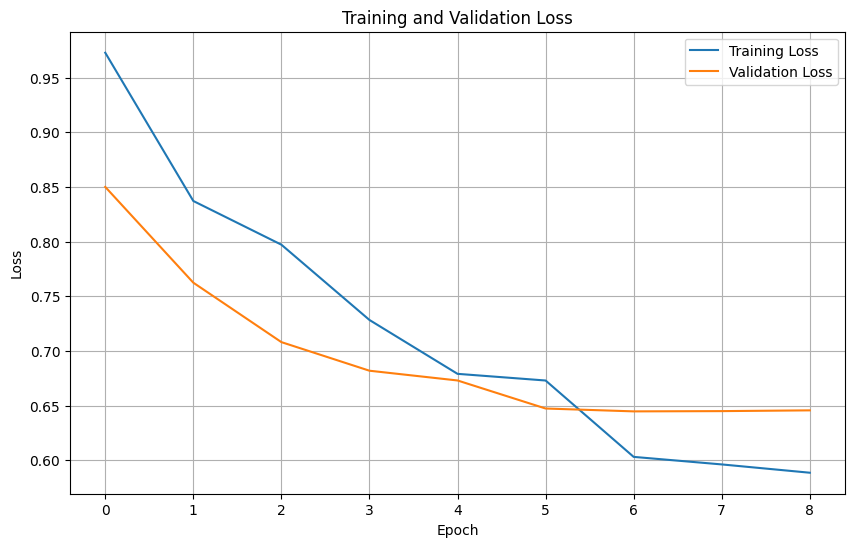

In [ ]:
# distilbert model
trainer = train_model(tokenized_datasets['train'], tokenized_datasets['valid'], model)


In [24]:
# distilbert model with dropout = 0.3
from transformers import AutoConfig, AutoModelForSequenceClassification

model_name = "distilbert-base-uncased"

# Load the model's configuration
config = AutoConfig.from_pretrained(model_name)

# Modify the dropout rate
config.attention_probs_dropout_prob = 0.3
config.hidden_dropout_prob = 0.3

# Set the number of labels (classification task)
config.num_labels = 4  # Set the number of labels for your task

# Now, load the model with the modified configuration
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
100,0.971800,0.858355
200,0.842700,0.780810
300,0.802600,0.724110
400,0.746700,0.697000
500,0.703400,0.683313
600,0.692900,0.677040


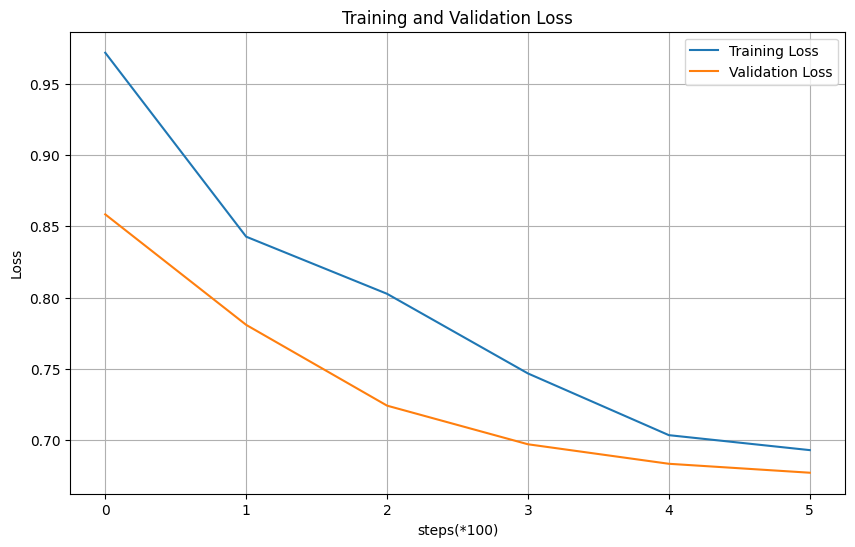

In [12]:
# distilbert model with dropout = 0.3
trainer01 = train_model(tokenized_datasets['train'], tokenized_datasets['valid'], model,epochs=2)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
100,1.280600,1.125877
200,1.112300,0.991420
300,1.033000,0.933341
400,0.958600,0.925114
500,0.896600,0.919754
600,0.894300,0.912621


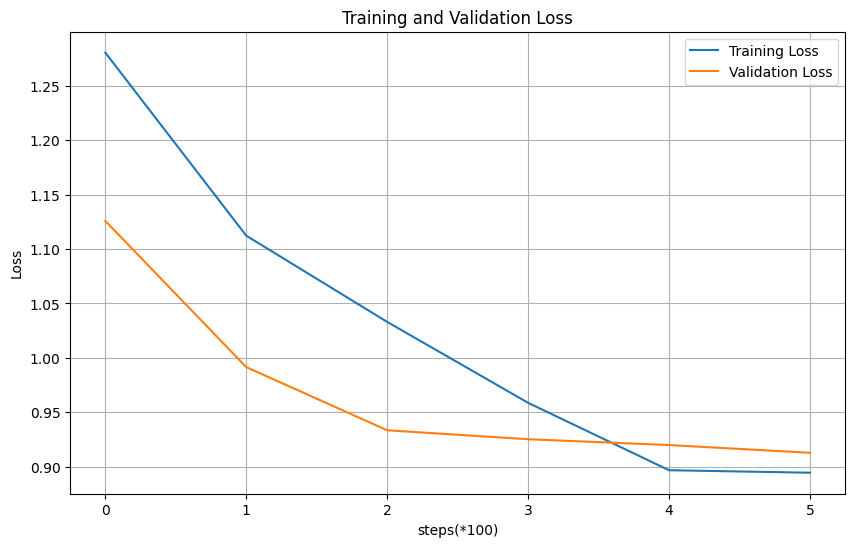

In [27]:
# distilbert model with dropout = 0.3 and class weights
trainer02 = train_model_with_weights(tokenized_datasets['train'], tokenized_datasets['valid'], model,epochs=2)

### Results

In [39]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,f1_score,precision_score,recall_score

In [32]:
def evaluate_model(true_labels, predicted_labels, label_mapping):
    reverse_mapping = {v: k for k, v in label_mapping.items()}
    true_labels_str = [reverse_mapping[label] for label in true_labels]
    predicted_labels_str = [reverse_mapping[label] for label in predicted_labels]

    print("Classification Report:\n", classification_report(true_labels_str, predicted_labels_str))
    cm = confusion_matrix(true_labels_str, predicted_labels_str, labels=list(label_mapping.keys()))
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [38]:
def evaluate_model_performance(trainer, test_dataset, test_labels, label_mapping):
    predictions = trainer.predict(test_dataset)
    predicted_labels = predictions.predictions.argmax(axis=1)
    accuracy = accuracy_score(test_labels, predicted_labels)
    macro_precision = precision_score(test_labels, predicted_labels, average='macro')
    macro_recall = recall_score(test_labels, predicted_labels, average='macro')
    f1 = f1_score(test_labels, predicted_labels, average='weighted')
    print(f'accuracy: {accuracy},f1: {f1}, precision:{macro_precision},recall:{macro_recall}')
    evaluate_model(test_labels, predicted_labels, label_mapping)

Classification Report:
               precision    recall  f1-score   support

       false       0.66      0.61      0.63       388
     mixture       0.35      0.53      0.42       201
        true       0.89      0.73      0.80       599
    unproven       0.23      0.42      0.30        45

    accuracy                           0.65      1233
   macro avg       0.53      0.57      0.54      1233
weighted avg       0.71      0.65      0.67      1233



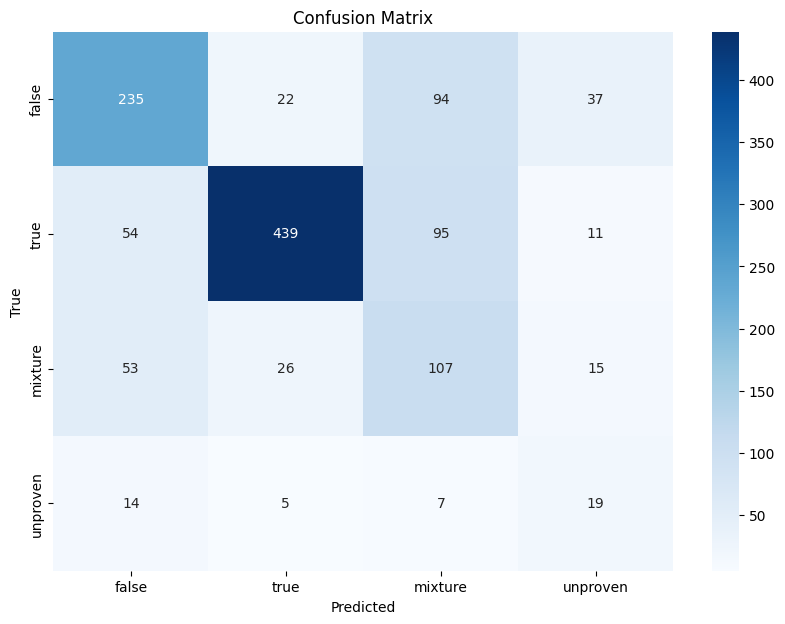

In [ ]:
# distilbert model
evaluate_model_performance(trainer, tokenized_datasets["test"], datasets["test"]["label"], label_mapping)

Classification Report:
               precision    recall  f1-score   support

       false       0.62      0.76      0.68       388
     mixture       0.36      0.30      0.32       201
        true       0.85      0.79      0.82       599
    unproven       0.34      0.27      0.30        45

    accuracy                           0.68      1233
   macro avg       0.54      0.53      0.53      1233
weighted avg       0.68      0.68      0.68      1233



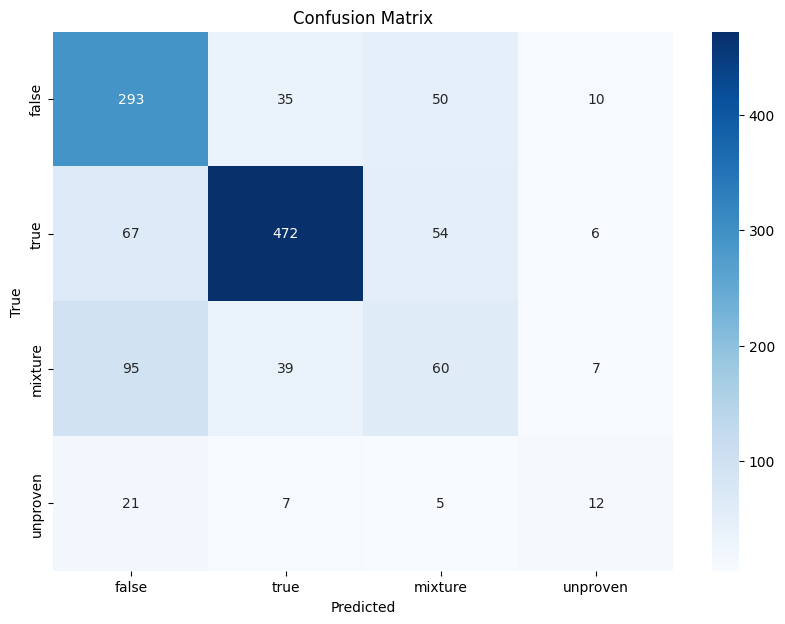

In [ ]:
# distilbert with dropout = 0.3 and 3 epochs
evaluate_model_performance(trainer1, tokenized_datasets["test"], datasets["test"]["label"], label_mapping)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

accuracy: 0.6853203568532036,f1: 0.6558935070608664, precision:0.46092490292049504,recall:0.4591839307840948
Classification Report:
               precision    recall  f1-score   support

       false       0.58      0.82      0.68       388
     mixture       0.44      0.20      0.28       201
        true       0.82      0.81      0.82       599
    unproven       0.00      0.00      0.00        45

    accuracy                           0.69      1233
   macro avg       0.46      0.46      0.44      1233
weighted avg       0.65      0.69      0.66      1233



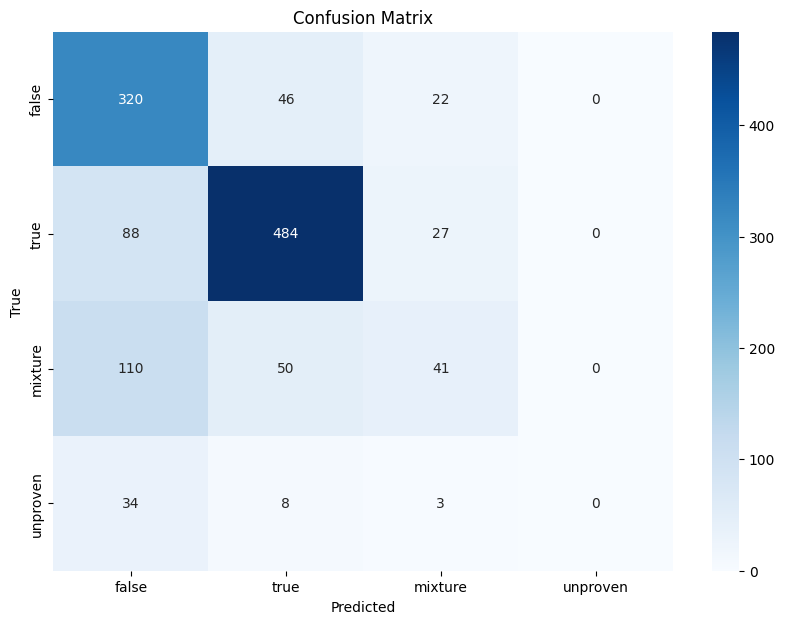

In [40]:
# distilbert with dropout = 0.3, epochs = 2
evaluate_model_performance(trainer01,tokenized_datasets['test'],datasets["test"]["label"], label_mapping)

accuracy: 0.6009732360097324,f1: 0.6338404604815066, precision:0.5073653561069718,recall:0.5577614843731649
Classification Report:
               precision    recall  f1-score   support

       false       0.63      0.49      0.55       388
     mixture       0.35      0.56      0.43       201
        true       0.90      0.70      0.79       599
    unproven       0.15      0.49      0.22        45

    accuracy                           0.60      1233
   macro avg       0.51      0.56      0.50      1233
weighted avg       0.70      0.60      0.63      1233



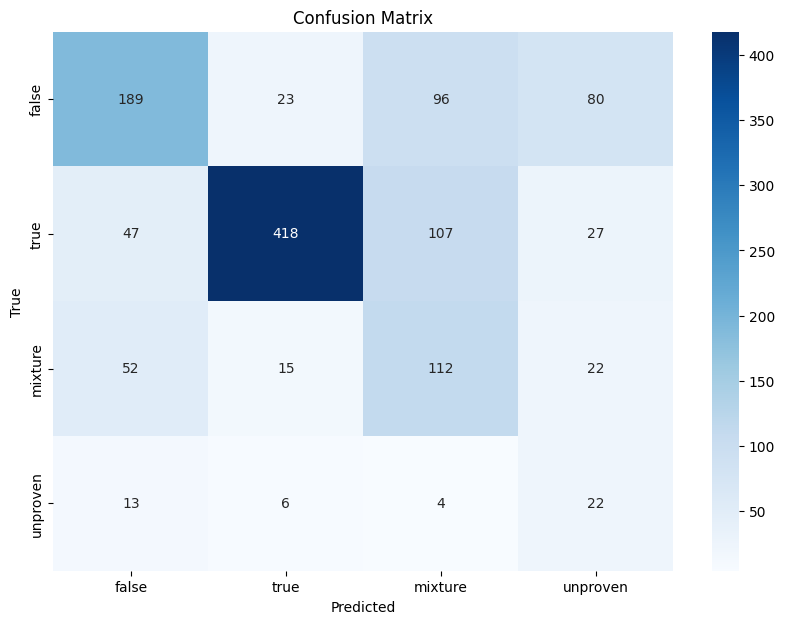

In [41]:
# distilbert with dropout = 0.3 epochs =2, class weights
evaluate_model_performance(trainer02,tokenized_datasets['test'],datasets["test"]["label"], label_mapping)